In [1]:
# Auto Reload
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
from collections import Counter
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
from pprint import pprint
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from math import log

In [3]:
# NLTK Modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Import Custom Modules
from src.cleaner import clean_data
from src.helpers import *

In [5]:
# Import Data
df = pd.read_csv('data/ufo_csv.csv')

In [6]:
# Clean Data
clean_df = clean_data(df)
clean_df['shape'].value_counts()

 Circle       17
 Light        13
 Other        12
 Sphere        8
 Disk          8
 Unknown       8
 Oval          7
 Triangle      6
 Rectangle     4
 Changing      3
 Formation     3
 Cylinder      2
 Fireball      2
 Diamond       2
 Flash         1
 Chevron       1
 Teardrop      1
               1
Name: shape, dtype: int64

In [7]:
# Create Documents
documents = clean_df['content']

In [8]:
# Set Stop Words
stop = set(stopwords.words('english'))
# Set Stop Punctuations
puncs = set(string.punctuation)
# Merge Stops
full_stop = stop.union(puncs)
# full_stop

In [9]:
# Tokenize Words from Documents
tokens = [word_tokenize(doc.lower()) for doc in documents]

# Filter each token for stop words
doc_filter = [filter_tokens(token, full_stop) for token in tokens]

# Compare Stemming/Lemmatization

In [10]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

docs_porter = [[porter.stem(word) for word in words]
               for words in doc_filter]
docs_snowball = [[snowball.stem(word) for word in words]
                 for words in doc_filter]
docs_wordnet = [[wordnet.lemmatize(word) for word in words]
                for words in doc_filter]

### Results

In [11]:
## Print the stemmed and lemmatized words from the first document
print("%16s | %16s | %16s | %16s |" % ("WORD", "PORTER", "SNOWBALL", "LEMMATIZER"))
for i in range(min(len(docs_porter[0]), len(docs_snowball[0]), len(docs_wordnet[0]))):
    p, s, w = docs_porter[0][i], docs_snowball[0][i], docs_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s | %16s | %16s | %16s |" % (doc_filter[0][i], p, s, w))

            WORD |           PORTER |         SNOWBALL |       LEMMATIZER |
         hovered |            hover |            hover |          hovered |
          looked |             look |             look |           looked |
      helicopter |         helicopt |         helicopt |       helicopter |
          stayed |             stay |             stay |           stayed |
     disappeared |        disappear |        disappear |      disappeared |
         appears |           appear |           appear |          appears |
              us |               us |               us |                u |
      consistent |          consist |          consist |       consistent |
        sighting |            sight |            sight |         sighting |
           venus |             venu |            venus |            venus |


### Snowball Stemmer Chosen
> We chose to stem the words with the Snowball Stemmer due to its preservation of important words for this usecase such as 'venus'


> The Snowball Stemmmer normalizes these words from its appeared form into their root form

In [12]:
# Stem Words in Each Document
clean_tokens = [list(map(snowball.stem, sent)) for sent in doc_filter]
# clean_tokens

In [13]:
# Check for stray tokens (ones with weird puncs, not alphabetical strings)
strays = []
for i in range(len(clean_tokens)):
#     print("--- sentence tokens (lemmatize): {}".format(tokens_lemmatize[i]))
    for word in clean_tokens[i]:
        if not word.isalpha():
            strays.append(word)
set(strays)

set()

### Turn Cleaned Tokens into Series

In [14]:
# Documents to series
document_series = pd.Series([" ".join(x) for x in clean_tokens])

In [15]:
documents[0]

"Light seen over mountain's east of Camp McGregor.  It hovered in one spot.  It looked like a helicopter light at first.  But it was way to bright.  Then it went to a higher height.  Stayed there for a while.  Then disappeared.((NUFORC Note:  Report appears to us to be consistent with the sighting of Venus.  PD))"

In [16]:
document_series[0]

'light seen mountain east camp mcgregor hover one spot look like helicopt light first way bright went higher height stay disappear nuforc note report appear us consist sight venus pd'

### Get Term Frequency

In [17]:
# term occurence = counting distinct words in each bag
term_occ = [Counter(doc) for doc in clean_tokens]
# term_occ

The number of times a term occurs in a specific document:

$tf(term,document) = \frac{\# \ of \ times \ a \ term \ appears \ in \ a \ document}{\#\ of\ terms\ in\ the\ document|}$

In [18]:
term_freq = list()
for i in range(len(clean_tokens)):
    term_freq.append( {k: (v / float(len(clean_tokens[i])))
                       for k, v in term_occ[i].items()} )
term_freq[0]

{'light': 0.06666666666666667,
 'seen': 0.03333333333333333,
 'mountain': 0.03333333333333333,
 'east': 0.03333333333333333,
 'camp': 0.03333333333333333,
 'mcgregor': 0.03333333333333333,
 'hover': 0.03333333333333333,
 'one': 0.03333333333333333,
 'spot': 0.03333333333333333,
 'look': 0.03333333333333333,
 'like': 0.03333333333333333,
 'helicopt': 0.03333333333333333,
 'first': 0.03333333333333333,
 'way': 0.03333333333333333,
 'bright': 0.03333333333333333,
 'went': 0.03333333333333333,
 'higher': 0.03333333333333333,
 'height': 0.03333333333333333,
 'stay': 0.03333333333333333,
 'disappear': 0.03333333333333333,
 'nuforc': 0.03333333333333333,
 'note': 0.03333333333333333,
 'report': 0.03333333333333333,
 'appear': 0.03333333333333333,
 'us': 0.03333333333333333,
 'consist': 0.03333333333333333,
 'sight': 0.03333333333333333,
 'venus': 0.03333333333333333,
 'pd': 0.03333333333333333}

### Get Document Frequencies

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$

In [28]:
doc_occ = Counter( [word for token in clean_tokens for word in set(token)] )

doc_freq = {k: (v / float(len(clean_tokens)))
            for k, v in doc_occ.items()}

# doc_freq

In [20]:
# See words with a high frequency threshhold 50%
thresh = 0.5
for word, freq in doc_freq.items():
    if freq >= thresh:
        print(f"{word}:  {freq}")

light:  0.6767676767676768
look:  0.5252525252525253
sky:  0.5656565656565656
saw:  0.5151515151515151
move:  0.5858585858585859


### Get Vocabulary

In [21]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.5

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),vocabulary))

-- vocabulary (len=5): ['light', 'look', 'sky', 'saw', 'move']


(array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 [157, 54, 15, 10, 5, 1, 0, 0, 0, 0])

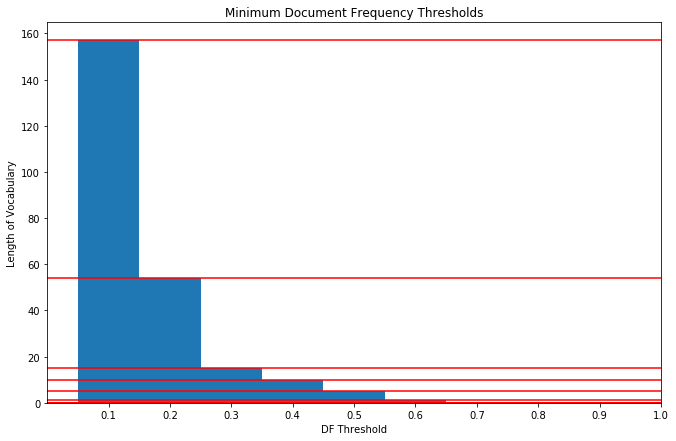

In [22]:
# Plot Minimum Document Frequency Threshold
x = np.arange(0.1, 1.1, 0.1)
vocab_y = [len([ k for k,v in doc_freq.items() if v >= thresh ]) for thresh in x]

fig, ax = plt.subplots(figsize=(11, 7))

ax.bar(x, vocab_y, width=0.1)

ax.set_xlim([0,1])
ax.set_title("Minimum Document Frequency Thresholds")

ax.set_xticks(x)

ax.set_xlabel("DF Threshold")
ax.set_ylabel("Length of Vocabulary")

for i, j in zip(x, vocab_y):
    ax.axhline(j, color='r')

x, vocab_y

In [23]:
all_vocabs = [[ k for k,v in doc_freq.items() if v >= thresh ] for thresh in x]
for vocab in all_vocabs:
    print("-- vocabulary (len={}): {}".format(len(vocab),vocab))

-- vocabulary (len=157): ['light', 'look', 'nuforc', 'helicopt', 'first', 'bright', 'pd', 'disappear', 'way', 'went', 'sight', 'report', 'seen', 'us', 'one', 'like', 'east', 'appear', 'note', 'hover', 'could', 'sky', 'provid', 'elect', 'stationari', 'star', 'inform', 'anonym', 'contact', 'remain', 'sourc', 'travel', 'notic', 'fli', 'someth', 'approxim', 'clear', 'see', 'would', 'wit', 'sound', 'come', 'direct', 'near', 'craft', 'saw', 'west', 'air', 'north', 'feet', 'object', 'tree', 'mayb', 'shape', 'side', 'view', 'size', 'orang', 'circl', 'never', 'hous', 'gone', 'pass', 'time', 'seem', 'move', 'low', 'almost', 'straight', 'white', 'plane', 'still', 'anoth', 'know', 'quick', 'toward', 'made', 'outsid', 'normal', 'stop', 'make', 'flash', 'mile', 'distanc', 'high', 'insid', 'chang', 'thought', 'go', 'minut', 'back', 'second', 'watch', 'show', 'around', 'two', 'ball', 'even', 'away', 'night', 'south', 'thing', 'came', 'point', 'color', 'end', 'green', 'complet', 'take', 'drive', 'refle

In [24]:
state_df = clean_df.groupby('state')["content"]

# Language Processing

### Create TFIDF Vector

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$

The inverse document frequency is defined in terms of the document frequency as

$idf(term,corpus) = \log{\frac{1}{df(term,corpus)}}$.


TF-IDF is an acronym for the product of two parts: the term frequency tf and what is called the inverse document frequency idf. The term frequency is just the counts in a term frequency vector. 

tf-idf $ = tf(term,document) * idf(term,corpus)$

In [25]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(document_series).todense()

#print(tf.vocabulary_)
#print(document_tf_matrix)

In [26]:
def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
#print(sorted(tf.vocabulary_))
#print(idf(document_tf_matrix))

In [27]:
tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(document_series)
print(sorted(tfidf.vocabulary_))
print(document_tfidf_matrix.todense())

['abl', 'abrupt', 'absolut', 'acceler', 'accord', 'account', 'acknowledg', 'acr', 'across', 'act', 'activ', 'actual', 'addendum', 'address', 'adjac', 'adrenalin', 'advertis', 'aerial', 'aerodynam', 'afbwhil', 'afraid', 'afternoon', 'againmi', 'agil', 'agl', 'ago', 'agre', 'ahead', 'air', 'aircraft', 'airforc', 'airlin', 'airplan', 'airplanew', 'airport', 'alabama', 'alarm', 'albani', 'albuquerqu', 'alien', 'alleg', 'allow', 'almost', 'alon', 'along', 'alot', 'alreadi', 'also', 'although', 'altitud', 'altitudei', 'aluminum', 'alway', 'amaz', 'amber', 'amend', 'anchorag', 'andi', 'andrew', 'angel', 'angl', 'anniston', 'anonym', 'anoth', 'answer', 'antiqu', 'anxieti', 'anybodi', 'anymor', 'anyon', 'anyth', 'anywher', 'apart', 'appar', 'appear', 'appendag', 'approach', 'approx', 'approxim', 'approximatley', 'april', 'aprox', 'arang', 'arc', 'arch', 'area', 'arizona', 'arm', 'armi', 'around', 'arrang', 'array', 'arrow', 'asap', 'ascertain', 'ask', 'asleep', 'aspirin', 'assum', 'asteroid', '